In [1]:
# Verificar GPU disponible
import torch
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

GPU disponible: True
GPU: Tesla T4
Memoria: 15.8 GB


In [2]:
# Clonar tu repositorio
!git clone https://github.com/BecerraMiguel/tokamak-fno.git
%cd tokamak-fno

Cloning into 'tokamak-fno'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 47 (delta 12), reused 39 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.30 MiB | 5.80 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/tokamak-fno


In [3]:
# Crear carpeta data si no existe
!mkdir -p data

# Generar datos sintéticos usando la función de conveniencia
from src.data.synthetic import create_default_dataset

dataset = create_default_dataset(
    output_path='data/tokamak_synthetic.h5',
    n_normal=500,
    n_disruptive=500,
    seed=42
)

GENERADOR DE DATOS SINTÉTICOS DE TOKAMAK

Parámetros:
  - Disparos normales: 500
  - Disparos disruptivos: 500
  - Semilla: 42
  - Archivo de salida: data/tokamak_synthetic.h5



Generando disparos disruptivos: 100%|██████████| 500/500 [00:01<00:00, 382.23it/s]


Dataset guardado en: data/tokamak_synthetic.h5
  - Disparos normales: 500
  - Disparos disruptivos: 500
  - Shape de datos: (1000, 5, 1000)

¡Dataset generado exitosamente!


In [5]:
from src.data.loader import get_dataloaders
from src.models.baseline import BaselineCNN, count_parameters

# Cargar datos
train_loader, val_loader, stats = get_dataloaders(
    h5_path='data/tokamak_synthetic.h5',
    batch_size=32,
    val_split=0.2,
    seed=42
)

print(f"Batches de entrenamiento: {len(train_loader)}")
print(f"Batches de validación: {len(val_loader)}")

# Crear modelo
model = BaselineCNN(in_channels=5, num_classes=2)
print(f"\nParámetros del modelo: {count_parameters(model):,}")

Batches de entrenamiento: 25
Batches de validación: 7

Parámetros del modelo: 81,634


In [6]:
from src.training.train import train_model

# Configuración de entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Entrenando en: {device}\n")

# Entrenar
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,           # 30 épocas máximo
    learning_rate=1e-3,  # 0.001
    device=device,
    save_dir='results',
    patience=7,          # Early stopping después de 7 épocas sin mejora
    verbose=True
)

Entrenando en: cuda

Entrenando en: cuda
Épocas máximas: 30
Learning rate: 0.001
Early stopping patience: 7
--------------------------------------------------
Época   1/30 | Train Loss: 0.6283 | Train Acc: 0.9075 | Val Loss: 0.0609 | Val Acc: 0.9800 | Tiempo: 1.3s
Época   2/30 | Train Loss: 0.0550 | Train Acc: 0.9862 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo: 0.1s
Época   3/30 | Train Loss: 0.0067 | Train Acc: 0.9962 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo: 0.1s
Época   4/30 | Train Loss: 0.0151 | Train Acc: 0.9962 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo: 0.1s
Época   5/30 | Train Loss: 0.0272 | Train Acc: 0.9938 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo: 0.1s
Época   6/30 | Train Loss: 0.0058 | Train Acc: 0.9975 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo: 0.1s
Época   7/30 | Train Loss: 0.0033 | Train Acc: 0.9988 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo: 0.1s
Época   8/30 | Train Loss: 0.0072 | Train Acc: 0.9988 | Val Loss: 0.0000 | Val Acc: 1.0000 | Tiempo

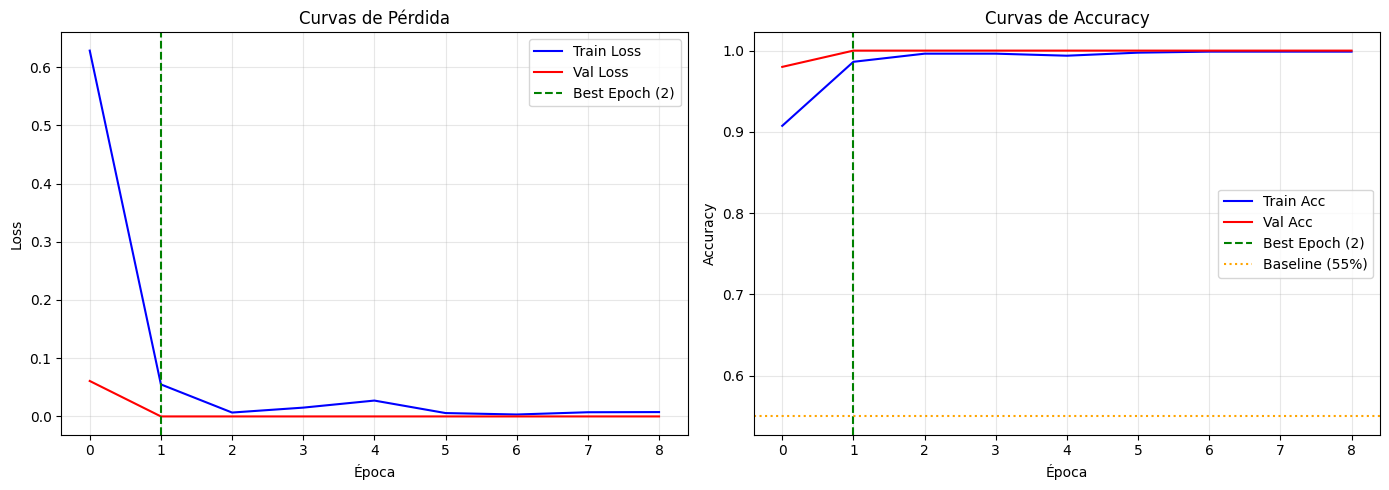


Mejor accuracy de validación: 1.0000 (100.0%)
Alcanzado en época: 2


In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curva de Loss
axes[0].plot(history['train_losses'], label='Train Loss', color='blue')
axes[0].plot(history['val_losses'], label='Val Loss', color='red')
axes[0].axvline(x=history['best_epoch']-1, color='green', linestyle='--',
                label=f'Best Epoch ({history["best_epoch"]})')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Curvas de Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Curva de Accuracy
axes[1].plot(history['train_accs'], label='Train Acc', color='blue')
axes[1].plot(history['val_accs'], label='Val Acc', color='red')
axes[1].axvline(x=history['best_epoch']-1, color='green', linestyle='--',
                label=f'Best Epoch ({history["best_epoch"]})')
axes[1].axhline(y=0.55, color='orange', linestyle=':', label='Baseline (55%)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Curvas de Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMejor accuracy de validación: {history['best_val_acc']:.4f} ({history['best_val_acc']*100:.1f}%)")
print(f"Alcanzado en época: {history['best_epoch']}")

In [8]:
import os
from google.colab import files

model_saved = os.path.exists('results/best_model.pt')
files.download('results/best_model.pt')



VERIFICACIÓN - CHECKPOINT DÍA 5

1. ¿Loss decrece? ✓
   Loss inicial: 0.6283
   Loss final:   0.0075

2. ¿Validation Accuracy > 55%? ✓
   Mejor accuracy: 100.0%

3. ¿Modelo guardado en results/best_model.pt? ✓

✓ ¡CHECKPOINT DÍA 5 COMPLETADO!
